In [0]:
#To list the contents of the directory and confirm the presence of the clinical trial and pharma dataset
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/FaultDataset.csv', name='FaultDataset.csv', size=1703184, modificationTime=1681130859000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data-1.csv', name='Occupancy_Detection_Data-1.csv', size=50968, modificationTime=1677787556000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1677786498000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1675772618000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=16752682

In [0]:
#Assign the clinialtrial_2021 dataset to the variable 'fileroot' and copy it from the DBFS to the tmp folder.
fileroot = "clinicaltrial_2021"
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")

Out[2]: True

In [0]:
#Make the fileroot variable accessible 
import os
os.environ['fileroot'] = fileroot

In [0]:
%sh                           
unzip -d /tmp /tmp/$fileroot.zip

Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  


In [0]:
#creates a new directory in the DBFS
dbutils.fs.mkdirs("/FileStore/tables/" + fileroot)

#move the file to the /filestore/tables directory,name it clinicaltrial_2021.csv and overwrite the file if it already exists
dbutils.fs.mv("file:/tmp/clinicaltrial_2021.csv", "/FileStore/tables/clinicaltrial_2021.csv", True)

Out[5]: True

In [0]:
#remove the zip file
dbutils.fs.rm("/FileStore/tables/" + fileroot + ".zip")

#Check the contents of the directory
dbutils.fs.ls("/FileStore/tables/" + fileroot)

Out[6]: []

In [0]:
#create an rdd named clinicaltrial_rdd
clinicaltrial_rdd = sc.textFile("/FileStore/tables/clinicaltrial_2021.csv")

In [0]:
#Assign the pharma dataset to the variable 'fileroot' and copy it from the DBFS to the tmp folder.
fileroot = "pharma"
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")

Out[8]: True

In [0]:
%sh
ls /tmp


Rserv
RtmpnILTUa
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2021.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
pharma.zip
systemd-private-ddf4ff41fe07431eaeeca843ff9b5362-apache2.service-WzkzWf
systemd-private-ddf4ff41fe07431eaeeca843ff9b5362-ntp.service-4Z8h8g
systemd-private-ddf4ff41fe07431eaeeca843ff9b5362-systemd-logind.service-3ZC7li
systemd-private-ddf4ff41fe07431eaeeca843ff9b5362-systemd-resolved.service-KwVkzh
tmp.nB1P8g9Agi


In [0]:
#Make the fileroot variable accessible 
import os
os.environ['fileroot'] = fileroot

In [0]:
%sh                           
unzip -d /tmp /tmp/$fileroot.zip

Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
#creates a new directory in the DBFS
dbutils.fs.mkdirs("/FileStore/tables/" + fileroot)

#move the file to the /filestore/tables directory,name it pharma.csv and overwrite the file if it already exists
dbutils.fs.mv("file:/tmp/pharma.csv", "/FileStore/tables/pharma.csv", True)

Out[12]: True

In [0]:
#remove the zip file
dbutils.fs.rm("/FileStore/tables/" + fileroot + ".zip")

#Check the contents of the directory
dbutils.fs.ls("/FileStore/tables/" + fileroot)

Out[13]: []

In [0]:
#create an rdd named pharma_rdd
pharma_rdd = sc.textFile("/FileStore/tables/pharma.csv")

In [0]:
clinicaltrial_rdd = sc.textFile("/FileStore/tables/clinicaltrial_2021.csv")
header = clinicaltrial_rdd.first()
clinicaltrial_rdd = clinicaltrial_rdd.filter(lambda row: row != header) # Remove the header

clinicaltrial_rdd = clinicaltrial_rdd.distinct() # Remove duplicates


In [0]:
num_distinct_studies = clinicaltrial_rdd.distinct().count()         #count the number of distinct studies in the clinical trials RDD

print(f"Number of distinct studies: {num_distinct_studies}")       #print the result

Number of distinct studies: 387261


In [0]:

types_rdd = clinicaltrial_rdd.map(lambda line: line.split("|")[5]) #creates a new rdd by selecting the 6th column(types column)

types_rdd_count = types_rdd.countByValue() #counts the number of each distinct type

types_rdd_count = sorted(types_rdd_count.items(), key=lambda x: x[1], reverse=True) #sort in descending order the count of each value


for type_, count in types_rdd_count:
    
    print(type_, count)


Interventional 301472
Observational 77540
Observational [Patient Registry] 8180
Expanded Access 69


In [0]:
conditions_rdd = clinicaltrial_rdd.map(lambda line: line.split("|")[7]) #create a new rdd by mapping the 7th column

split_conditions_rdd = conditions_rdd.flatMap(lambda x: x.split(",")).filter(lambda x: x.strip() != '') #split each line and filter out whitespace or empty values


top_conditions_rdd = split_conditions_rdd.countByValue().items()  #creates a dictionary with the frequency count of each condition 
top_conditions_rdd = sorted(top_conditions_rdd, key=lambda x: x[1], reverse=True)[:5] #sort result in descending order with limit 5


print("Top 5 conditions with their frequencies:")
for condition, count in top_conditions_rdd:
    print(f"{condition}: {count}")

Top 5 conditions with their frequencies:
Carcinoma: 13389
Diabetes Mellitus: 11080
Neoplasms: 9371
Breast Neoplasms: 8640
Syndrome: 8032


In [0]:
sponsors = clinicaltrial_rdd.map(lambda line: (line.split("|")[1], 1)) #extract all sponsors from the clinical trial rdd
sponsors.take(10)

Out[19]: [('The University of Hong Kong', 1),
 ('Duke University', 1),
 ('Universidade Federal do Rio de Janeiro', 1),
 ('University of Roma La Sapienza', 1),
 ('Consorzio Futuro in Ricerca', 1),
 ('Washington University School of Medicine', 1),
 ('Daniel Alexandre Bottino', 1),
 ('Institut für Pharmakologie und Präventive Medizin', 1),
 ('Tel Aviv Medical Center', 1),
 ('James Cook University, Queensland, Australia', 1)]

In [0]:
pharma_rdd_split = pharma_rdd.map(lambda x: x.split(",")) #split each element in the pharma rdd
pharma_rdd_split.take(10)


Out[20]: [['"Company"',
  '"Parent_Company"',
  '"Penalty_Amount"',
  '"Subtraction_From_Penalty"',
  '"Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting"',
  '"Penalty_Year"',
  '"Penalty_Date"',
  '"Offense_Group"',
  '"Primary_Offense"',
  '"Secondary_Offense"',
  '"Description"',
  '"Level_of_Government"',
  '"Action_Type"',
  '"Agency"',
  '"Civil/Criminal"',
  '"Prosecution_Agreement"',
  '"Court"',
  '"Case_ID"',
  '"Private_Litigation_Case_Title"',
  '"Lawsuit_Resolution"',
  '"Facility_State"',
  '"City"',
  '"Address"',
  '"Zip"',
  '"NAICS_Code"',
  '"NAICS_Translation"',
  '"HQ_Country_of_Parent"',
  '"HQ_State_of_Parent"',
  '"Ownership_Structure"',
  '"Parent_Company_Stock_Ticker"',
  '"Major_Industry_of_Parent"',
  '"Specific_Industry_of_Parent"',
  '"Info_Source"',
  '"Notes"'],
 ['"Abbott Laboratories"',
  '"Abbott Laboratories"',
  '"$5',
  '475',
  '000"',
  '"$0"',
  '"$5',
  '475',
  '000"',
  '"2013"',
  '"20131227"',
  '"government-contracting-related off

In [0]:
Parent_company = pharma_rdd_split.map(lambda x: (x[1].replace('"', ''), 1))#extract the parent company
Parent_company.take(5)

Out[21]: [('Parent_Company', 1),
 ('Abbott Laboratories', 1),
 ('AbbVie', 1),
 ('AbbVie', 1),
 (' Inc.', 1)]

In [0]:
common_sponsor = sponsors.subtract(Parent_company) #subtract the parent company rdd from the sponsors rdd to get sponsors that are not pharmaceutical companies
common_sponsor.take(5)

Out[22]: [('Consorzio Futuro in Ricerca', 1),
 ('Consorzio Futuro in Ricerca', 1),
 ('Daniel Alexandre Bottino', 1),
 ('Tel Aviv Medical Center', 1),
 ('Tel Aviv Medical Center', 1)]

In [0]:
common_sponsors_not_pharmaceutical_companies = common_sponsor.reduceByKey(lambda v1, v2: v1+v2).sortBy(lambda x: x[1], False) #get sponsors that are not pharmaceutical companies with their decreasing frequency
common_sponsors_not_pharmaceutical_companies.take(10) #Print the top 10 sponsors that are not pharmaceutical companies

Out[23]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

In [0]:
# map each row to a tuple containing the 3rd and 5th elements of the row
status_completion_data = clinicaltrial_rdd.map(lambda x: x.split("|")[2:5:2])

# Collect the extracted data as a list of lists
status_completion_data = status_completion_data.collect()

print(status_completion_data[:12])

[['Recruiting', 'Nov 2021'], ['Completed', 'Jul 2020'], ['Completed', 'Jan 2018'], ['Active, not recruiting', 'Sep 2020'], ['Completed', 'Jan 2018'], ['Completed', 'Jul 2017'], ['Completed', 'Dec 2015'], ['Completed', 'May 2019'], ['Unknown status', 'Jun 2017'], ['Completed', 'Oct 2019'], ['Completed', 'Apr 2015'], ['Completed', '']]


In [0]:
# Create an RDD from a list
clinicaltrial_rdd1 = sc.parallelize(status_completion_data)

clinicaltrial_rdd1 = clinicaltrial_rdd1.filter(lambda x: x[0]== "Completed") # filtering the resulting RDD "clinicaltrial_rdd1" to contain only the tuples where the first element is "Completed"

clinicaltrial_rdd1.take(12)

Out[25]: [['Completed', 'Jul 2020'],
 ['Completed', 'Jan 2018'],
 ['Completed', 'Jan 2018'],
 ['Completed', 'Jul 2017'],
 ['Completed', 'Dec 2015'],
 ['Completed', 'May 2019'],
 ['Completed', 'Oct 2019'],
 ['Completed', 'Apr 2015'],
 ['Completed', ''],
 ['Completed', 'Nov 2020'],
 ['Completed', 'Mar 2017'],
 ['Completed', 'Jul 2016']]

In [0]:
clinicaltrial_rdd1 = clinicaltrial_rdd1.map(lambda x: x[1].split(" ")).filter(lambda x: '2021' in x[-1]) #split the second element of the tuple on spaces, creating a list of strings,only those tuples where the last string in the list contains the substring "2021" are included.

clinicaltrial_rdd1  = clinicaltrial_rdd1 .map(lambda x: x[0]).map(lambda r:(r,1)) #extract the first element of the list which is month name with integer 1 as the second element

clinicaltrial_rdd1 = clinicaltrial_rdd1.reduceByKey(lambda a,b: a+b) #group the tuple by key(month name) and use the lambda function to add up the integer

clinicaltrial_rdd1.take(12)

Out[26]: [('Apr', 967),
 ('Aug', 700),
 ('Sep', 528),
 ('May', 984),
 ('Mar', 1227),
 ('Jun', 1094),
 ('Jan', 1131),
 ('Feb', 934),
 ('Oct', 187),
 ('Jul', 819)]

In [0]:
clinicaltrial_rdd1 = [('Aug', 700),
 ('Apr', 967),
 ('Sep', 528),
 ('May', 984),
 ('Jun', 1094),
 ('Mar', 1227),
 ('Jan', 1131),
 ('Feb', 934),
 ('Jul', 819),
 ('Oct', 187)]

# Create a dictionary to map month names to their corresponding order
month_order = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

# Sort the result list using the month_order dictionary as the key for sorting
sorted_clinicaltrial_rdd1 = sorted(clinicaltrial_rdd1, key=lambda x:month_order[x[0]])

# Iterate through each tuple in the sorted result list and format the output string
output = [f"{month} {count}" for month, count in sorted_clinicaltrial_rdd1]

# Join the formatted strings with newlines
Number_of_completed_studies = "\n".join(output)

# Print the formatted output
print(Number_of_completed_studies)

Jan 1131
Feb 934
Mar 1227
Apr 967
May 984
Jun 1094
Jul 819
Aug 700
Sep 528
Oct 187


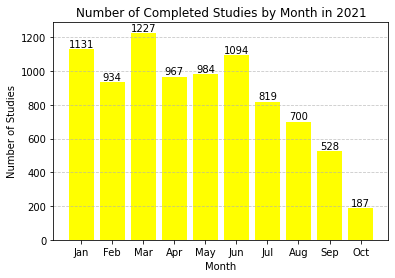

In [0]:
import matplotlib.pyplot as plt

sorted_clinicaltrial_rdd1 = [('Jan', 1131),
                             ('Feb', 934),
                             ('Mar', 1227),
                             ('Apr', 967),
                             ('May', 984),
                             ('Jun', 1094),
                             ('Jul', 819),
                             ('Aug', 700),
                             ('Sep', 528),
                             ('Oct', 187)]
                                  
# Extract the months and counts from the sorted result list
months = [x[0] for x in sorted_clinicaltrial_rdd1]
counts = [x[1] for x in sorted_clinicaltrial_rdd1]

# Create a bar chart using Matplotlib
plt.bar(months, counts, color='yellow')

# Set the title and labels for the chart
plt.title('Number of Completed Studies by Month in 2021')
plt.xlabel('Month')
plt.ylabel('Number of Studies')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to the bars
for i in range(len(months)):
    plt.annotate(counts[i], xy=(months[i], counts[i]), ha='center', va='bottom', fontsize=10)

# Show the chart
plt.show()


In [0]:
# Load clinical trial data into an RDD
clinicaltrial_rdd = sc.textFile("/FileStore/tables/clinicaltrial_2021.csv")

# Split each line into a list of values
header = clinicaltrial_rdd.first()
clinicaltrial_rdd = clinicaltrial_rdd.filter(lambda line: line != header).map(lambda line: line.split("|"))

# Map each condition to its study type and count the number of occurrences
condition_type_count_rdd = clinicaltrial_rdd.flatMap(lambda line: [(condition, line[5]) for condition in line[7].split(",")]) \
    .countByValue()

# Print the top 30 results
counter = 0
for (condition_type, count) in sorted(condition_type_count_rdd.items(), key=lambda x: x[1], reverse=True):
    if counter < 10:
        print("{}: {}".format(condition_type, count))
        counter += 1
    else:
        break


('', 'Interventional'): 51323
('', 'Observational'): 12699
('Carcinoma', 'Interventional'): 11449
('Diabetes Mellitus', 'Interventional'): 9084
('Neoplasms', 'Interventional'): 8138
('Breast Neoplasms', 'Interventional'): 6981
('Syndrome', 'Interventional'): 6138
('Leukemia', 'Interventional'): 5168
('Lymphoma', 'Interventional'): 4878
('Lung Neoplasms', 'Interventional'): 4606


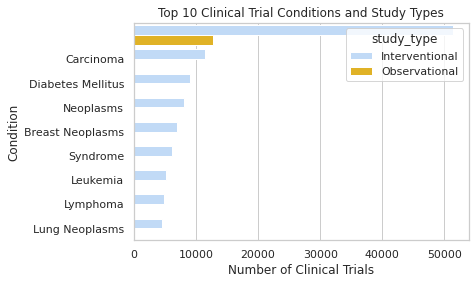

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Create a DataFrame from the result dictionary
df = pd.DataFrame.from_dict(condition_type_count_rdd, orient='index', columns=['count'])
df.reset_index(inplace=True)
df[['condition', 'study_type']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df.drop(['index'], axis=1, inplace=True)

# Sort the DataFrame by count in descending order and keep only the top 10
df_top = df.sort_values(by=['count'], ascending=False).head(10)

# Plot the stacked bar chart
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x="count", y="condition", hue="study_type", data=df_top, palette=["#b8daff", "#ffc107"])

# Set the plot title and axes labels
plt.title("Top 10 Clinical Trial Conditions and Study Types")
plt.xlabel("Number of Clinical Trials")
plt.ylabel("Condition")

# Display the plot
plt.show()
